### Imports and setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install -U segmentation-models

     |████████████████████████████████| 50 kB 3.0 MB/s 


In [3]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import segmentation_models as sm
import os
import matplotlib.image as mpimg
from PIL import Image
import cv2

Segmentation Models: using `keras` framework.


### Extracting data and masks

In [4]:
def extract_data(folderpath):
    """ (ETH) Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].

    Parameters
    ----------
    filename: string
        The name of the image file
    num_images: int
        The number of images that should be extracted

    Returns
    -------
    data: ndarray
        A numpy array containting the images
    """
    files = os.listdir(folderpath)
    n = len(files)
    imgs = [(mpimg.imread(folderpath+files[i])) for i in range(n)]
    data = np.asarray(imgs)
    return data

def extract_data_test(folderpath):
    """ (ETH) Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].

    Parameters
    ----------
    filename: string
        The name of the image file
    num_images: int
        The number of images that should be extracted

    Returns
    -------
    data: ndarray
        A numpy array containting the images
    """
    imgs=[]
    for i in range(1,51):
      img = mpimg.imread(folderpath+'test_%d.png'%i)
      imgs.append(img)
    data = np.asarray(imgs)
    return data


def extract_labels(folderpath):
    """ (ETH) Extract the labels into a 1-hot matrix [image index, label index].
    
    Parameters
    ----------
    filename: string
        The name of the image file
    num_images: int
        The number of images
    
    Returns
    --------
    labels: ndarray
        1-hot matrix [image index, label index]
    """
    gt_imgs = []
    files = os.listdir(folderpath)
    n = len(files)
    for i in range(n):
        img = mpimg.imread(folderpath+files[i])
        try:
            gt_imgs.append(img[:,:,0])
        except:
            gt_imgs.append(img)

    return np.asarray(gt_imgs)

In [5]:
!unzip "/content/drive/My Drive/ml/data.zip" -d "/content"

Archive:  /content/drive/My Drive/ml/data.zip
   creating: /content/data_volt/training/
   creating: /content/data_volt/training/groundtruth/
  inflating: /content/data_volt/training/groundtruth/satImage_001.png  
  inflating: /content/data_volt/training/groundtruth/satImage_001_Aug00.png  
  inflating: /content/data_volt/training/groundtruth/satImage_001_Aug01.png  
  inflating: /content/data_volt/training/groundtruth/satImage_001_Aug02.png  
  inflating: /content/data_volt/training/groundtruth/satImage_001_Aug03.png  
  inflating: /content/data_volt/training/groundtruth/satImage_001_Aug04.png  
  inflating: /content/data_volt/training/groundtruth/satImage_001_Aug05.png  
  inflating: /content/data_volt/training/groundtruth/satImage_001_Aug06.png  
  inflating: /content/data_volt/training/groundtruth/satImage_001_Aug07.png  
  inflating: /content/data_volt/training/groundtruth/satImage_001_Aug08.png  
  inflating: /content/data_volt/training/groundtruth/satImage_001_Aug09.png  
  infl

In [6]:
train_data_path = '/content/data_volt/training/images/'
train_labels_path = '/content/data_volt/training/groundtruth/'

x_train = extract_data(train_data_path)
y_train = extract_labels(train_labels_path)

In [7]:
x_val = x_train[1360:]
y_val = y_train[1360:]
x_train = x_train[0:1360]
y_train = y_train[0:1360]

### Model time

In [8]:
sm.set_framework('tf.keras')
import math
keras.backend.clear_session()
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
from sklearn.model_selection import train_test_split

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)


In [9]:

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape=(256, 256, 3))

# adding a l2 kernel regularizer
sm.utils.set_regularization(model, kernel_regularizer=keras.regularizers.l2(1))
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore(),'accuracy'],
)

# saving the best model
callbacks = [keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/m6.h5", save_best_only=True)]

# training
history = model.fit(x=x_train, y=y_train,
   epochs=50, batch_size=32,
   callbacks=callbacks,
   validation_data=(x_val,y_val)
)


85532672/85521592 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
43/43 [==============================] - 78s 1s/step - loss: 1.0840 - iou_score: 0.3173 - f1-score: 0.4720 - accuracy: 0.6757 - val_loss: 3.7963 - val_iou_score: 8.4665e-09 - val_f1-score: 1.6905e-08 - val_accuracy: 0.7649
Epoch 2/50
43/43 [==============================] - 46s 1s/step - loss: 0.7195 - iou_score: 0.5270 - f1-score: 0.6897 - accuracy: 0.7358 - val_loss: 2.2874 - val_iou_score: 0.0330 - val_f1-score: 0.0639 - val_accuracy: 0.7649
Epoch 3/50
43/43 [==============================] - 42s 966ms/step - loss: 0.6146 - iou_score: 0.6012 - f1-score: 0.7506 - accuracy: 0.7446 - val_loss: 3.4945 - val_iou_score: 0.0094 - val_f1-score: 0.0187 - val_accuracy: 0.7649
Epoch 4/50
43/43 [==============================] - 41s 964ms/step - loss: 0.5686 - iou_score: 0.6349 - f1-score: 0.7764 - accuracy: 0.7489 - val_loss: 3.7957 - val_iou_score: 1.2973e-06 - val_f1-score: 2.5945e-06 - val_accuracy: 0.7649
Epoch 5/50
43/43 [==============================] - 46s 1s/step - loss: 0.

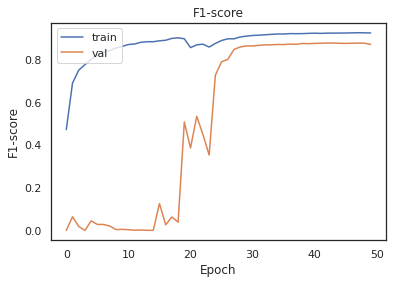

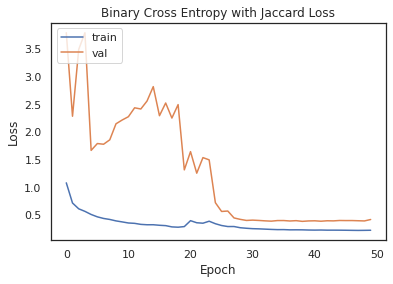

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("white")

# visualizing results
# summarize history for accuracy
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('f1_score.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy with Jaccard Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()

### Testing and predicting

In [13]:
!unzip "/content/drive/My Drive/ml/testing.zip" -d "/content"

Archive:  /content/drive/My Drive/ml/testing.zip
  inflating: /content/testing/test_1.png  
  inflating: /content/testing/test_10.png  
  inflating: /content/testing/test_11.png  
  inflating: /content/testing/test_12.png  
  inflating: /content/testing/test_13.png  
  inflating: /content/testing/test_14.png  
  inflating: /content/testing/test_15.png  
  inflating: /content/testing/test_16.png  
  inflating: /content/testing/test_17.png  
  inflating: /content/testing/test_18.png  
  inflating: /content/testing/test_19.png  
  inflating: /content/testing/test_2.png  
  inflating: /content/testing/test_20.png  
  inflating: /content/testing/test_21.png  
  inflating: /content/testing/test_22.png  
  inflating: /content/testing/test_23.png  
  inflating: /content/testing/test_24.png  
  inflating: /content/testing/test_25.png  
  inflating: /content/testing/test_26.png  
  inflating: /content/testing/test_27.png  
  inflating: /content/testing/test_28.png  
  inflating: /content/testing

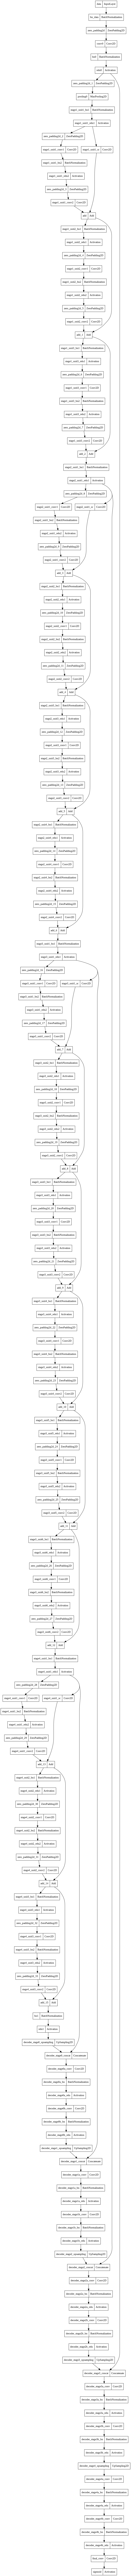

In [14]:
from keras.models import load_model

# loading the best model
model = load_model('/content/drive/MyDrive/Models/m5.h5', custom_objects
                   = {'binary_crossentropy_plus_jaccard_loss':sm.losses.bce_jaccard_loss, 
                      'iou_score': sm.metrics.iou_score, 'f1-score': sm.metrics.FScore()})

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model5.png')

#test_images = extract_data_test('/content/testing/')



In [15]:
# predicting on the validation set
y_pred = model.predict((x_val))
patch_size = 16

Checking which threshold for converting patch to foregroud is best on the val set

In [17]:
from sklearn.metrics import f1_score, accuracy_score
def patch_to_label(patch, thr):
    df = np.mean(patch)
    if df > thr:
        return 1
    else:
        return 0
thresholds = [0.01*i for i in range(0, 101)]
f1s = []
for thr in thresholds:
  highest=0
  y_pred_flattened = []
  for im in y_pred:
    for j in range(0, im.shape[1], patch_size):
          for i in range(0, im.shape[0], patch_size):
              patch = im[i:i + patch_size, j:j + patch_size]
              label = patch_to_label(patch, thr)
              y_pred_flattened.append(label)
  y_val_flattened = []
  for im in y_val:
    for j in range(0, im.shape[1], patch_size):
          for i in range(0, im.shape[0], patch_size):
              patch = im[i:i + patch_size, j:j + patch_size]
              label = patch_to_label(patch, thr)
              y_val_flattened.append(label)

  y_pred_flattened = np.array(y_pred_flattened)
  f1 = f1_score(y_val_flattened, y_pred_flattened)
  f1s.append(f1)
  if f1>highest:
    foreground_threshold=thr
  acc = accuracy_score(y_val_flattened, y_pred_flattened)
  print("Threshold: %.2f, F1-score: %.4f, Accuracy: %.4f"%(thr, f1, acc))

Threshold: 0.00, F1-score: 0.5233, Accuracy: 0.3543
Threshold: 0.01, F1-score: 0.9750, Accuracy: 0.9844
Threshold: 0.02, F1-score: 0.9763, Accuracy: 0.9855
Threshold: 0.03, F1-score: 0.9765, Accuracy: 0.9859
Threshold: 0.04, F1-score: 0.9764, Accuracy: 0.9860
Threshold: 0.05, F1-score: 0.9773, Accuracy: 0.9866
Threshold: 0.06, F1-score: 0.9774, Accuracy: 0.9868
Threshold: 0.07, F1-score: 0.9767, Accuracy: 0.9866
Threshold: 0.08, F1-score: 0.9766, Accuracy: 0.9866
Threshold: 0.09, F1-score: 0.9774, Accuracy: 0.9872
Threshold: 0.10, F1-score: 0.9776, Accuracy: 0.9875
Threshold: 0.11, F1-score: 0.9775, Accuracy: 0.9875
Threshold: 0.12, F1-score: 0.9778, Accuracy: 0.9878
Threshold: 0.13, F1-score: 0.9779, Accuracy: 0.9879
Threshold: 0.14, F1-score: 0.9771, Accuracy: 0.9876
Threshold: 0.15, F1-score: 0.9765, Accuracy: 0.9874
Threshold: 0.16, F1-score: 0.9760, Accuracy: 0.9872
Threshold: 0.17, F1-score: 0.9754, Accuracy: 0.9871
Threshold: 0.18, F1-score: 0.9753, Accuracy: 0.9871
Threshold: 0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Threshold: 0.99, F1-score: 0.0000, Accuracy: 1.0000
Threshold: 1.00, F1-score: 0.0000, Accuracy: 1.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


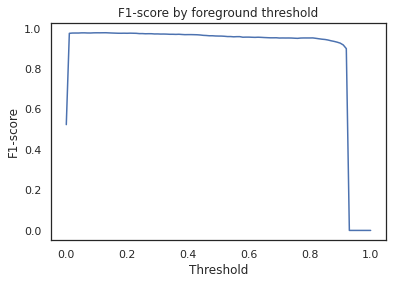

In [22]:
plt.plot(thresholds, f1s)
plt.title("F1-score by foreground threshold")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.savefig("thr.png")
plt.show()

#Generating predictions

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
test_images = extract_data_test('/content/testing/')



In [ ]:
# predicting on 256x256 crops of the test images
imgs = preprocess_input(x_val)
resultat = []
for img in imgs:
    img1 = img[0:256,0:256,:]
    img2 = img[0:256,144:,:]
    img4 = img[144:,0:256,:]
    img5 = img[144:,144:,:]
    pred_1 = model.predict(np.expand_dims(img1, axis=0))[0]
    pred_2 = model.predict(np.expand_dims(img2, axis=0))[0]
    pred_4 = model.predict(np.expand_dims(img4, axis=0))[0]
    pred_5 = model.predict(np.expand_dims(img5, axis=0))[0]

    pred_2 = pred_2[:,112:,:]
    pred_4 = pred_4[112:,:,:]
    pred_5 = pred_5[112:,112:,:]
    a = np.hstack([pred_1,pred_2])
    b = np.hstack([pred_4,pred_5])
    d = np.vstack([a,b])
    resultat.append(d)

In [ ]:
d.shape

(400, 400, 1)

In [ ]:
def img_float_to_uint8(img):
    '''converts image array with floats to uint8
    
    parameters
    -----------
    img: ndarray
        image array
    
    returns
    -------
    rimg: ndarray
        converted array'''

    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# generating the prediction masks testset
for i in range(len(resultat)):
  img = resultat[i]
  w = img.shape[0]
  h = img.shape[1]
  gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
  gt_img8 = img_float_to_uint8(img)          
  gt_img_3c[:, :, 0] = gt_img8[:,:,0]
  gt_img_3c[:, :, 1] = gt_img8[:,:,0]
  gt_img_3c[:, :, 2] = gt_img8[:,:,0]

  cv2.imwrite('/content/drive/MyDrive/Pred/test%d.png'%(i+1),gt_img_3c)


In [ ]:
# saving mask predictions on the validation set
for i in range(len(y_pred)):
  img = y_pred[i]
  w = img.shape[0]
  h = img.shape[1]
  gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
  gt_img8 = img_float_to_uint8(img)          
  gt_img_3c[:, :, 0] = gt_img8[:,:,0]
  gt_img_3c[:, :, 1] = gt_img8[:,:,0]
  gt_img_3c[:, :, 2] = gt_img8[:,:,0]

  cv2.imwrite('/content/drive/MyDrive/masks/test%d.png'%(i+1),gt_img_3c)

In [ ]:
#!/usr/bin/env python3

import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.04 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


# generating the prediction file for the test set
submission_filename = '/content/drive/MyDrive/Pred/m5.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = '/content/drive/MyDrive/Pred/test%d.png' % i
    print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)


/content/drive/MyDrive/Pred/test1.png
/content/drive/MyDrive/Pred/test2.png
/content/drive/MyDrive/Pred/test3.png
/content/drive/MyDrive/Pred/test4.png
/content/drive/MyDrive/Pred/test5.png
/content/drive/MyDrive/Pred/test6.png
/content/drive/MyDrive/Pred/test7.png
/content/drive/MyDrive/Pred/test8.png
/content/drive/MyDrive/Pred/test9.png
/content/drive/MyDrive/Pred/test10.png
/content/drive/MyDrive/Pred/test11.png
/content/drive/MyDrive/Pred/test12.png
/content/drive/MyDrive/Pred/test13.png
/content/drive/MyDrive/Pred/test14.png
/content/drive/MyDrive/Pred/test15.png
/content/drive/MyDrive/Pred/test16.png
/content/drive/MyDrive/Pred/test17.png
/content/drive/MyDrive/Pred/test18.png
/content/drive/MyDrive/Pred/test19.png
/content/drive/MyDrive/Pred/test20.png
/content/drive/MyDrive/Pred/test21.png
/content/drive/MyDrive/Pred/test22.png
/content/drive/MyDrive/Pred/test23.png
/content/drive/MyDrive/Pred/test24.png
/content/drive/MyDrive/Pred/test25.png
/content/drive/MyDrive/Pred/test26

In [ ]:
# generating the prediction file for the validation set
submission_filename = '/content/drive/MyDrive/masks/m1.csv'
image_filenames = []
for i in range(1, 341):
    image_filename = '/content/drive/MyDrive/masks/test%d.png' % i
    print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)

/content/drive/MyDrive/masks/test1.png
/content/drive/MyDrive/masks/test2.png
/content/drive/MyDrive/masks/test3.png
/content/drive/MyDrive/masks/test4.png
/content/drive/MyDrive/masks/test5.png
/content/drive/MyDrive/masks/test6.png
/content/drive/MyDrive/masks/test7.png
/content/drive/MyDrive/masks/test8.png
/content/drive/MyDrive/masks/test9.png
/content/drive/MyDrive/masks/test10.png
/content/drive/MyDrive/masks/test11.png
/content/drive/MyDrive/masks/test12.png
/content/drive/MyDrive/masks/test13.png
/content/drive/MyDrive/masks/test14.png
/content/drive/MyDrive/masks/test15.png
/content/drive/MyDrive/masks/test16.png
/content/drive/MyDrive/masks/test17.png
/content/drive/MyDrive/masks/test18.png
/content/drive/MyDrive/masks/test19.png
/content/drive/MyDrive/masks/test20.png
/content/drive/MyDrive/masks/test21.png
/content/drive/MyDrive/masks/test22.png
/content/drive/MyDrive/masks/test23.png
/content/drive/MyDrive/masks/test24.png
/content/drive/MyDrive/masks/test25.png
/content/